In [1]:
import jax
jax.devices()

[CudaDevice(id=0)]

In [2]:
# This script generates the plasma surface, winding surface and initial filaments for the 
# force minimization study. Uses the regcoil branch and quadcoil_proto.

import os
# os.environ['XLA_FLAGS'] = '--xla_dump_to=./jax_dump'
# os.environ['JAX_PLATFORMS'] = 'cpu'
import sys
import cvxpy
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier, plot
from simsopt.field import CurrentPotentialSolve, CurrentPotentialFourier
from simsopt import save, load
from functools import partial
from jax import jit, vmap, jacfwd
from jax.lax import while_loop
import optax
import optax.tree_utils as otu
import time


# Loading QUADCOIL
quadcoil_path = '..'
sys.path.insert(1, quadcoil_path)
# The directory of the c++ code imported in self_force_operator
# must be included separately
sys.path.insert(1, quadcoil_path + '/build')
sys.path.insert(1, quadcoil_path + '/objectives')

from winding_surface_jax import (
    gen_winding_surface_atan,
    dof_to_gamma, 
    winding_surface_field_Bn, 
    cp_make_mn, 
    winding_surface_field_Bn_GI
)
from jax_solver import solve_quad_unconstrained, eval_quad_scaled, solve_quad_constrained, run_opt
from plotting_utils import plot_coil_Phi_IG
from grid_curvature_operator_jax import grid_curvature_cylindrical
from f_b_and_k_operators_jax import \
    f_B_and_current_scale, \
    K2, K_theta, K_helper
from utils import avg_order_of_magnitude
import cvxpy_utils


# Loading plasma surface and setting up parameters (replace with your own equilibrium and parameters)

In [3]:
''' --- Loading configs --- '''


# Obtaining a list of all configs
path_plasma_surface = 'plasma_surface/'
list_plasma_surface = os.listdir(path_plasma_surface)
path_vcasing = '2023-09-14.MagneticGradientScalength/vcasing/'
list_vcasing= os.listdir(path_vcasing)
path_bnorm = '2023-09-14.MagneticGradientScalength/bnorm/'
list_bnorm = os.listdir(path_bnorm)
''

''

In [4]:
# Finding a case with name containing the substring. 
# You can change current_name to something you like.
substring='li383'
print('Finding equilibrium containing:', substring)
for i_config, item in enumerate(list_plasma_surface):
    if substring in item:
        break

print(i_config)

current_plasma_surface = list_plasma_surface[i_config]
current_name = current_plasma_surface[:-4]
print('Name:', current_name)



Finding equilibrium containing: li383
21
Name: li383_1.4m_aScaling


In [5]:
''' --- Settings --- '''
n_phi_plasma = 31
n_theta_plasma = 31
# n_phi is per field period
n_phi_winding = 32
n_theta_winding = 32
# In this test file, winding and eval 
# grids must be the same because that's
# how it is in the mosek version. Otherwise
# the comparison will not be valid.
n_phi_eval = n_phi_winding
n_theta_eval = n_theta_winding

# The first constraint is a peak current density constraint that mimics the 
# coil-coil distance constraint in filament optimization. 
# Here we prescribe some arbitrary coil number by multiplying this 
# number to the aspect ratio. The more coils there are, the more accurate the 
# proxy should be
coil_per_aspect_ratio = 4.6503866245115155
mpol_cp = 4
ntor_cp = 4


mpol_winding = 7 # 10
ntor_winding = 7 # 10


In [6]:

''' --- Loading plasma surface --- '''

# Loads the plasma surface into plasma_surface. Replace with your own surface.
surf_dict = np.load(path_plasma_surface + current_plasma_surface, allow_pickle=True).item()
plasma_dofs = surf_dict['dofs']
stellsym = surf_dict['stellsym']
nfp = surf_dict['nfp']
quadpoints_phi_plasma = jnp.linspace(0, 1/nfp, n_phi_plasma, endpoint=False)
quadpoints_theta_plasma = jnp.linspace(0, 1, n_theta_plasma, endpoint=False)
plasma_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=surf_dict['mpol'], 
    ntor=surf_dict['ntor'], 
    quadpoints_phi=quadpoints_phi_plasma, 
    quadpoints_theta=quadpoints_theta_plasma, 
)
plasma_surface.set_dofs(plasma_dofs)


''' --- Setting current --- '''


net_poloidal_current_amperes = surf_dict['net_poloidal_current']
net_toroidal_current_amperes = 0


''' --- Loading B_plasma --- '''


# Loads the normal magnetic field at the plasma surface
current_vcasing = 'vcasing_' + current_name + '.nc'
current_bnorm = 'bnorm.' + current_name
if current_bnorm in list_bnorm:
    print(current_bnorm, 'found. Loading virtual casing.')
    bnorm_data = np.loadtxt(path_bnorm+current_bnorm)
    bnorm_m = np.array(bnorm_data[:, 0], dtype=int)
    bnorm_n = np.array(bnorm_data[:, 1], dtype=int)
    bnorm_values = bnorm_data[:, 2]
    eval_grid_phi, eval_grid_theta = np.meshgrid(
        plasma_surface.quadpoints_phi, 
        plasma_surface.quadpoints_theta,
        indexing='ij'
    )
    Bnormal_plasma = np.sum(bnorm_values[:, None, None] * np.sin(
        bnorm_m[:, None, None] * eval_grid_phi[None, :, :] * np.pi * 2
        + bnorm_n[:, None, None] * eval_grid_theta[None, :, :] * np.pi * 2
    ), axis=0)
else:
    if current_vcasing in list_vcasing:
        raise TypeError('Equilibrium has no B_norm, but is not a vacuum field! '\
            'This requires virtual_casing to run, which is not functioning '\
            'properly.')
    Bnormal_plasma = np.zeros((
        len(plasma_surface.quadpoints_phi),
        len(plasma_surface.quadpoints_theta)
    ))

Bnormal_plasma_flat = Bnormal_plasma.flatten()



bnorm.li383_1.4m_aScaling found. Loading virtual casing.


In [7]:
''' --- Calculating aspect ratio --- '''
plasma_aspect = plasma_surface.aspect_ratio()
total_coil_num_temp = coil_per_aspect_ratio * plasma_aspect
coils_per_half_field_period = round(total_coil_num_temp/2/plasma_surface.nfp)
total_coil_num = coils_per_half_field_period*2*plasma_surface.nfp



''' --- Calculating constraint values --- '''
# Set your min coil coil distance constraint here
coil_coil_distance = 0.5 * plasma_surface.minor_radius()
kappa_threshold = 1/(0.2 * plasma_surface.minor_radius())
coil_plasma_distance = plasma_surface.minor_radius()



In [8]:
''' Settings '''
current_per_coil = net_poloidal_current_amperes/total_coil_num
max_K2 = (current_per_coil/coil_coil_distance)**2
max_KK = max_K2 * kappa_threshold

# The actual proxy for that plasma surface
Given coil-coil, coil-plasma spacing and maximum curvature requirements

In [9]:
quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_winding*nfp, endpoint=False)
quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_winding, endpoint=False)
quadpoints_phi_eval = jnp.linspace(0, 1/nfp, n_phi_eval, endpoint=False)
quadpoints_theta_eval = jnp.linspace(0, 1, n_theta_eval, endpoint=False)
mpol_plasma = plasma_surface.mpol
ntor_plasma = plasma_surface.ntor

In [10]:
quadpoints_theta_plasma.shape

(31,)

In [11]:
# This is necessary to calculate gammadashes.

# @partial(jit, static_argnames=[
#     'nfp', 
#     'stellsym', 
#     'mpol_plasma',
#     'ntor_plasma',
#     'mpol_winding',
#     'ntor_winding',
# ])
def plasma_dofs_to_winding_dofs(
    # Dofs
    plasma_dofs,
    # Equilibrium and related parameters
    # Coil parameters
    coil_plasma_distance,
    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=10, 
    ntor_winding=10,
):

    theta_mesh_plasma, phi_mesh_plasma = jnp.meshgrid(quadpoints_theta_plasma, quadpoints_phi_plasma)

    ''' Plasma surface calculations'''
    # Quadrature points
    gamma_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_plasma, ntor=ntor_plasma)

    ''' Generating winding surface '''

    winding_dofs = gen_winding_surface_atan(
        gamma_plasma=gamma_plasma, 
        d_expand=coil_plasma_distance, 
        nfp=nfp, stellsym=stellsym,
        unitnormal=None,
        mpol=mpol_winding, ntor=ntor_winding,
        tol_expand=0.9,
        lam_tikhnov=0.9,
    )
    return(winding_dofs, gamma_plasma)

In [12]:

@partial(jit, static_argnames=[
    'nfp', 
    'stellsym', 
    'mpol_plasma',
    'ntor_plasma',
    'mpol_winding',
    'ntor_winding',
    'mpol_cp', 
    'ntor_cp', 
    'init_mode',
    'tol_outer',
    'tol_inner',
    'max_iter_inner',
    'max_iter_outer',
    'n_phi_eval_default',
    'n_theta_eval_default',
])
def quadcoil_curvature_study(
    # Dofs
    plasma_dofs,

    # Equilibrium and related parameters
    Bnormal_plasma,
    net_poloidal_current_amperes, # G
    net_toroidal_current_amperes, # I

    # Coil parameters
    coil_plasma_distance,
    max_K2,
    max_KK,

    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=10,
    ntor_winding=10,
    quadpoints_phi_winding=None,
    quadpoints_theta_winding=None,
    mpol_cp=4, 
    ntor_cp=4, 
    quadpoints_phi_eval=None,
    quadpoints_theta_eval=None,
    init_mode='zero',
    tol_outer=1e-3, # was 1e-5
    tol_inner=1e-3,
    max_iter_inner=1500,
    max_iter_outer=25,
    n_phi_eval_default=32,
    n_theta_eval_default=32,
):
    # Default quadrature point number
    if quadpoints_phi_winding is None:
        quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_eval_default*nfp, endpoint=False, dtype=jnp.bfloat16)
        quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False, dtype=jnp.bfloat16)
    if quadpoints_phi_eval is None:
        quadpoints_phi_eval = jnp.linspace(0, 1/nfp, n_phi_eval_default, endpoint=False, dtype=jnp.bfloat16)
        quadpoints_theta_eval = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False, dtype=jnp.bfloat16)
    
    
    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2
    # Angle coordinates in a mesh
    theta_mesh_winding, phi_mesh_winding = jnp.meshgrid(quadpoints_theta_winding, quadpoints_phi_winding)
    theta_mesh_plasma, phi_mesh_plasma = jnp.meshgrid(quadpoints_theta_plasma, quadpoints_phi_plasma)
    theta_mesh_eval, phi_mesh_eval = jnp.meshgrid(quadpoints_theta_eval, quadpoints_phi_eval)

    # Flattening constant normal field
    Bnormal_plasma_flat = Bnormal_plasma.flatten()


    ''' Plasma surface calculations'''
    gammadash1_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_plasma, ntor=ntor_plasma)

    gammadash2_plasma = dof_to_gamma(
        dofs=plasma_dofs,
        phi_grid=phi_mesh_plasma, 
        theta_grid=theta_mesh_plasma, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_plasma, ntor=ntor_plasma)
    normal_plasma = jnp.cross(gammadash1_plasma, gammadash2_plasma, axis=-1)


    ''' Generating winding surface '''
    winding_dofs, gamma_plasma = plasma_dofs_to_winding_dofs(
        # Dofs
        plasma_dofs=plasma_dofs,
        # Equilibrium and related parameters
        # Coil parameters
        coil_plasma_distance=coil_plasma_distance,
        # Numerical parameters
        nfp=nfp, 
        stellsym=stellsym, 
        mpol_plasma=mpol_plasma,
        ntor_plasma=ntor_plasma,
        quadpoints_phi_plasma=quadpoints_phi_plasma,
        quadpoints_theta_plasma=quadpoints_theta_plasma,
        mpol_winding=mpol_winding, 
        ntor_winding=ntor_winding,
    )


    ''' Winding surface calculations '''
    # Winding operators
    # Operators
    gamma_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2_winding = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_winding, 
        theta_grid=theta_mesh_winding, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gamma_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1dash1_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=2,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash1dash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash1_order=1, dash2_order=1,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    gammadash2dash2_eval = dof_to_gamma(
        dofs=winding_dofs,
        phi_grid=phi_mesh_eval, 
        theta_grid=theta_mesh_eval, 
        nfp=nfp, 
        stellsym=stellsym, 
        dash2_order=2,
        mpol=mpol_winding, 
        ntor=ntor_winding
    )
    # Evaluation quadrature points
    normal_eval = jnp.cross(gammadash1_eval, gammadash2_eval, axis=-1)
    # Winding quadrature points (for calculating f_B)
    normal_winding = jnp.cross(gammadash1_winding, gammadash2_winding, axis=-1)


    ''' Calculating the NESCOIL (field error) operator '''
    m_cp, n_cp = cp_make_mn(mpol_cp, ntor_cp, stellsym)

    if stellsym:
        ndofs_half = ndof_cp
    else:
        ndofs_half = ndof_cp // 2
    dzeta_plasma = (quadpoints_phi_plasma[1] - quadpoints_phi_plasma[0])
    dtheta_plasma = (quadpoints_theta_plasma[1] - quadpoints_theta_plasma[0])
    dzeta_coil = (quadpoints_phi_winding[1] - quadpoints_phi_winding[0])
    dtheta_coil = (quadpoints_theta_winding[1] - quadpoints_theta_winding[0])

    normal_plasma_flat = normal_plasma.reshape(-1, 3)
    normal_winding_flat = normal_winding.reshape(-1, 3)
    points_plasma_flat = gamma_plasma.reshape(-1, 3)
    points_coil_flat = gamma_winding.reshape(-1, 3)
    gammadash1_winding_flat = gammadash1_winding.reshape(-1, 3)
    gammadash2_winding_flat = gammadash2_winding.reshape(-1, 3)

    gj_unscaled, _ = winding_surface_field_Bn(
        points_plasma_flat, # contig(points_plasma), 
        points_coil_flat, # contig(points_coil), 
        normal_plasma_flat, # contig(normal_plasma), 
        normal_winding_flat, # contig(normal), 
        stellsym, # self.winding_surface.stellsym, 
        jnp.ravel(phi_mesh_winding), # contig(zeta_coil), 
        jnp.ravel(theta_mesh_winding), # contig(theta_coil), 
        ndof_cp, # dummy, but used to keep the function signature the same
        m_cp[:ndofs_half], # contig(self.current_potential.m[:ndofs_half]), 
        n_cp[:ndofs_half], # contig(self.current_potential.n[:ndofs_half]), 
        nfp# self.winding_surface.nfp
    )
    gj = gj_unscaled * jnp.sqrt(dzeta_plasma * dtheta_plasma * dzeta_coil ** 2 * dtheta_coil ** 2)

    normN_plasma = jnp.linalg.norm(normal_plasma, axis=-1)
    B_GI = winding_surface_field_Bn_GI(
        points_plasma_flat, # points_plasma, 
        points_coil_flat, # points_coil, 
        normal_plasma_flat, # normal_plasma,
        jnp.ravel(phi_mesh_winding), # zeta_coil, 
        jnp.ravel(theta_mesh_winding), # theta_coil, 
        net_poloidal_current_amperes, # G
        net_toroidal_current_amperes, # I
        gammadash1_winding_flat, # gammadash1, 
        gammadash2_winding_flat, # gammadash2
    ) * dzeta_coil * dtheta_coil

    normN_plasma = jnp.linalg.norm(normal_plasma_flat, axis=-1)
    b_e = - jnp.sqrt(normN_plasma * dzeta_plasma * dtheta_plasma) * (B_GI + Bnormal_plasma_flat)


    ''' Calculating operators '''
    sign_windowpane = -jnp.sign(net_poloidal_current_amperes)
    A_f_B, b_f_B, c_f_B, B_normal, current_scale = f_B_and_current_scale(
        gj=gj,
        b_e=b_e,
        plasma_normal=normal_plasma,
        nfp=nfp
    )
    A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
        gamma=gamma_eval,
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        gammadash1dash1=gammadash1dash1_eval,
        gammadash1dash2=gammadash1dash2_eval,
        gammadash2dash2=gammadash2dash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K2, b_K2, c_K2 = K2(
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K_theta, b_K_theta, c_K_theta = K_theta(
            net_poloidal_current_amperes,
            quadpoints_phi_eval,
            quadpoints_theta_eval,
            nfp, m_cp, n_cp,
            stellsym,
    )


    ''' Claculating initial guess '''
    if init_mode=='zero':
        phi_scaled_init = jnp.zeros(ndof_cp, dtype=jnp.float64)
    elif init_mode=='nescoil':
        phi_nescoil, _ = solve_quad_unconstrained(A_f_B, b_f_B, c_f_B)
        phi_scaled_init = phi_nescoil*current_scale


    ''' Scaling objectives '''
    scale_f_B = avg_order_of_magnitude(c_f_B)
    scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
    scale_K2 = avg_order_of_magnitude(c_K2)
    scale_K_theta = avg_order_of_magnitude(c_K_theta)


    ''' Flattening operators'''
    # Flatten all operators and taking stellarator symmetry into account
    A_K_theta_obj = A_K_theta.reshape((-1, ndof_cp, ndof_cp))
    b_K_theta_obj = b_K_theta.reshape((-1, ndof_cp))
    c_K_theta_obj = c_K_theta.flatten()
    A_K2_obj = A_K2.reshape((-1, ndof_cp, ndof_cp))
    b_K2_obj = b_K2.reshape((-1, ndof_cp))
    c_K2_obj = c_K2.flatten()
    A_KK_cyl_obj = A_KK_cyl.reshape((-1, 3, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl.reshape((-1, 3, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl.reshape((-1, 3))
    if stellsym:
        print(A_KK_cyl.shape[0] * A_KK_cyl.shape[1])
        # Taking just half of the grid points is incorrect, 
        # because our grid DOES NOT INCLUDE ENDPOINTS!
        # This formula isn't exactly the number of unique 
        # gridpoints, but it's an over-estimate of it, 
        # ensuring that no info is lost.
        loop_size_K_l2 = (A_KK_cyl.shape[0] + 1) * (A_KK_cyl.shape[1] + 1) // 2
    else:
        loop_size_K_l2 = A_KK_cyl.shape[0] * A_KK_cyl.shape[1]
    A_K2_obj = A_K2_obj[:loop_size_K_l2]
    b_K2_obj = b_K2_obj[:loop_size_K_l2]
    c_K2_obj = c_K2_obj[:loop_size_K_l2]
    A_KK_cyl_obj = A_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl_obj[:loop_size_K_l2].reshape((-1))
    A_K_theta_obj = A_K_theta_obj[:loop_size_K_l2]
    b_K_theta_obj = b_K_theta_obj[:loop_size_K_l2]
    c_K_theta_obj = c_K_theta_obj[:loop_size_K_l2]


    ''' Combining all constraints into 3 big arrays '''
    A_total = jnp.concatenate([
        A_K2_obj/scale_K2, 
        -A_K2_obj/scale_K2, 
        A_KK_cyl_obj/scale_KK_cyl, 
        -A_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * A_K_theta_obj/scale_K_theta
    ], axis=0)

    b_total = jnp.concatenate([
        b_K2_obj/scale_K2, 
        -b_K2_obj/scale_K2, 
        b_KK_cyl_obj/scale_KK_cyl, 
        -b_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * b_K_theta_obj/scale_K_theta
    ], axis=0)

    c_total = jnp.concatenate([
        c_K2_obj/scale_K2 - max_K2/scale_K2, 
        -c_K2_obj/scale_K2 - max_K2/scale_K2, 
        c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        -c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        sign_windowpane * c_K_theta_obj/scale_K_theta
    ], axis=0)

    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2


    ''' Solving QUADCOIL '''
    res_quadcoil = solve_quad_constrained(
        x_init=phi_scaled_init,
        c_init=100,
        A_f=A_f_B/scale_f_B, 
        b_f=b_f_B/scale_f_B, 
        c_f=c_f_B/scale_f_B,
        mu_init=jnp.zeros_like(c_total),
        A_ineq=A_total, 
        b_ineq=b_total, 
        c_ineq=c_total,
        current_scale=current_scale,
        tol_outer=tol_outer, # was 1e-5
        tol_inner=tol_inner,
        max_iter_inner=max_iter_inner,
        max_iter_outer=max_iter_outer,
    )
    return(
        res_quadcoil['x_k']/current_scale, 
        winding_dofs, 
        A_K_theta, b_K_theta, c_K_theta 
    )



In [13]:
(
    quadcoil_sln, 
    winding_dofs, 
    A_K_theta_test, b_K_theta_test, c_K_theta_test 
) = quadcoil_curvature_study(
    plasma_dofs=plasma_dofs, # Dofs
    Bnormal_plasma=Bnormal_plasma, # Equilibrium and related parameters
    net_poloidal_current_amperes=net_poloidal_current_amperes, # G
    net_toroidal_current_amperes=net_toroidal_current_amperes, # I
    coil_plasma_distance=coil_plasma_distance, # Coil parameters
    max_K2=max_K2,
    max_KK=max_KK,
    mpol_cp=mpol_cp,
    ntor_cp=ntor_cp,
    nfp=nfp, # Numerical parameters
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma,
    quadpoints_theta_plasma=quadpoints_theta_plasma,
    mpol_winding=mpol_winding,
    ntor_winding=ntor_winding,
    quadpoints_phi_winding=quadpoints_phi_winding,
    quadpoints_theta_winding=quadpoints_theta_winding,
    quadpoints_phi_eval=quadpoints_phi_eval,
    quadpoints_theta_eval=quadpoints_theta_eval,
    tol_outer=1e-5,
    tol_inner=1e-5,
)

gamma_plasma_expand (31, 31, 3)
KK inputs -----------------
normal (32, 32, 3)
gammadash1 (32, 32, 3)
gammadash2 (32, 32, 3)
gammadash1dash1 (32, 32, 3)
gammadash1dash2 (32, 32, 3)
gammadash2dash2 (32, 32, 3)
net_poloidal_current_amperes ()
net_toroidal_current_amperes ()
quadpoints_phi (32,)
quadpoints_theta (32,)
---------------------------
A_KK_cyl (32, 32, 3, 40, 40)
A_KK (32, 32, 3, 40, 40)
b_KK_cyl (32, 32, 3, 40)
b_KK (32, 32, 3, 40)
c_KK_cyl (32, 32, 3)
c_KK (32, 32, 3)
1024


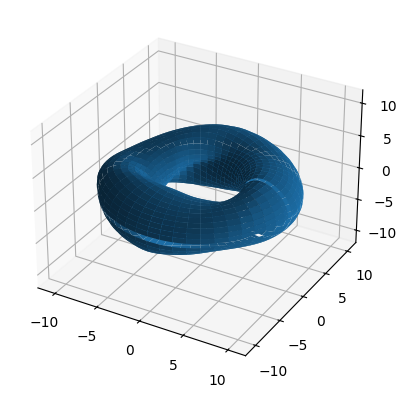

(96, 32)


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

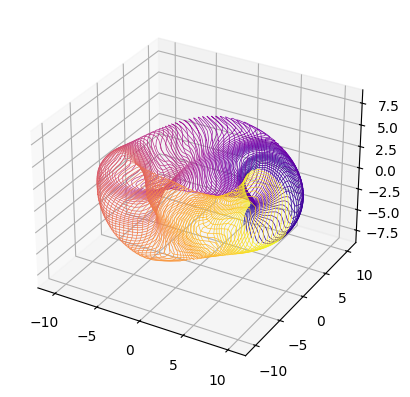

In [17]:
''' --- Calculating normalized field error of the solution --- '''
winding_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=mpol_winding, 
    ntor=ntor_winding, 
    quadpoints_phi=quadpoints_phi_winding, 
    quadpoints_theta=quadpoints_theta_winding, 
)
winding_surface.set_dofs(winding_dofs)
winding_surface.plot()
cp_temp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0,
    quadpoints_phi=winding_surface.quadpoints_phi,
    quadpoints_theta=winding_surface.quadpoints_theta,
    stellsym=winding_surface.stellsym
)
cp_temp.set_dofs(quadcoil_sln)
# Bfield = WindingSurfaceField(cp_temp)
# tgt_shape = (
#     len(plasma_surface.quadpoints_phi), 
#     len(plasma_surface.quadpoints_theta)
# )
# Jf_actual = SquaredFlux(
#     plasma_surface, 
#     Bfield, 
#     target=Bnormal_plasma_flat.reshape(tgt_shape),
#     definition='quadratic flux'
# )

# Jf_norm = SquaredFlux(
#     plasma_surface, 
#     Bfield, 
#     target=Bnormal_plasma_flat.reshape(tgt_shape),
#     definition='normalized'
# )
# Returns the predicted field error, the predicted normalized field error, 
# and the sheet current these errors are measured from
plot_coil_Phi_IG(cp_temp)

# Comparing with MOSEK sln

In [18]:
from operator_helper import A_b_c_to_block_operator

cp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0,
    quadpoints_phi=quadpoints_phi_winding,
    quadpoints_theta=quadpoints_theta_winding,
    stellsym=winding_surface.stellsym
)

Bnormal_plasma_flat = Bnormal_plasma.flatten()

cpst = CurrentPotentialSolve(
    cp=cp, 
    plasma_surface=plasma_surface,
    Bnormal_plasma=Bnormal_plasma_flat,
)

optimized_phi_mn, f_B_nescoil, _ = cpst.solve_tikhonov(lam=0)


/mnt/c/Work/codes/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


In [19]:
A_f_B, b_f_B, c_f_B, B_normal, current_scale = f_B_and_current_scale(
    gj=cpst.gj,
    b_e=cpst.b_e,
    plasma_normal=plasma_surface.normal(),
    nfp=cp.nfp
)
A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
    gamma=winding_surface.gamma(),
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    gammadash1dash1=winding_surface.gammadash1dash1(),
    gammadash1dash2=winding_surface.gammadash1dash2(),
    gammadash2dash2=winding_surface.gammadash2dash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=cp.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=cp.stellsym,
)
A_KK_cyl = A_KK_cyl[:A_KK_cyl.shape[0]//cp.nfp]
b_KK_cyl = b_KK_cyl[:b_KK_cyl.shape[0]//cp.nfp]
c_KK_cyl = c_KK_cyl[:c_KK_cyl.shape[0]//cp.nfp]

A_K2, b_K2, c_K2 = K2(
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=winding_surface.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=winding_surface.stellsym,
)

A_K2 = A_K2[:A_K2.shape[0]//cp.nfp]
b_K2 = b_K2[:b_K2.shape[0]//cp.nfp]
c_K2 = c_K2[:c_K2.shape[0]//cp.nfp]

A_K_theta, b_K_theta, c_K_theta = K_theta(
        cp.net_poloidal_current_amperes,
        cp.quadpoints_phi,
        cp.quadpoints_theta,
        cp.nfp, cp.m, cp.n,
        cp.stellsym,
)
A_K_theta = A_K_theta[:A_K_theta.shape[0]//cp.nfp]
b_K_theta = b_K_theta[:b_K_theta.shape[0]//cp.nfp]
c_K_theta = c_K_theta[:c_K_theta.shape[0]//cp.nfp]

scale_f_B = avg_order_of_magnitude(c_f_B)
scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
scale_K2 = avg_order_of_magnitude(c_K2)
scale_K_theta = avg_order_of_magnitude(c_K_theta)

In [20]:

''' Defining unknown '''
n_dof = len(cp.get_dofs())
cvxpy_X, constraints_X = cvxpy_utils.cvxpy_create_X(n_dof)
''' f_B '''
f_B_x_operator_scaled, f_B_scale = A_b_c_to_block_operator(
    A=A_f_B, b=b_f_B, c=c_f_B, 
    current_scale=current_scale,
    normalize=True
)
''' No windowpane '''
(
    constraints_no_windowpane, 
    K_theta_operator, 
    K_theta_scale
) = cvxpy_utils.cvxpy_no_windowpane(cp, current_scale, cvxpy_X)
''' K constraint set '''
AK_l2_operator_raw, AK_l2_scale = A_b_c_to_block_operator(
    A=A_K2, b=b_K2, c=c_K2, 
    current_scale=current_scale,
    normalize=True
)

AKK_operator_raw, AKK_scale = A_b_c_to_block_operator(
    A=A_KK_cyl, b=b_KK_cyl, c=c_KK_cyl, 
    current_scale=current_scale,
    normalize=True
)
# Reshaping
AK_l2_operator = AK_l2_operator_raw.reshape([-1] + list(AK_l2_operator_raw.shape[-2:]))
AKK_operator = AKK_operator_raw.reshape([-1] + list(AKK_operator_raw.shape[-2:]))

Testing net current sign


In [21]:
''' Solving with MOSEK '''
constraints_K_sq_max = []
if cp.stellsym:
    loop_size_K_l2 = AK_l2_operator.shape[0]//2
else:
    loop_size_K_l2 = AK_l2_operator.shape[0]
for i in range(loop_size_K_l2):
    constraints_K_sq_max.append(cvxpy.trace(AK_l2_operator[i, :, :] @ cvxpy_X) <= max_K2/AK_l2_scale)
''' K dot nabla K L1 and Linf constraint set '''
K_dot_nabla_K_comp_scaled_flat = AKK_operator.reshape((
    -1, 3, AKK_operator.shape[-2], AKK_operator.shape[-1]
))
constraints_kdotnablak, p = cvxpy_utils.cvxpy_create_Linf_from_array(
    K_dot_nabla_K_comp_scaled_flat, 
    cvxpy_X, 
    cp.stellsym
)
constraints_kdotnablak_limit = [
    p <= max_KK/AKK_scale
]
try:
    mosek_sln = np.load('mosek_sln.npy')
except:
    print("CVXPY+MOSEK sln not available. Calculating from scratch.") 
    import mosek
    cvxpy_K_sq_max = cvxpy.Problem(
        cvxpy.Minimize(cvxpy.trace(f_B_x_operator_scaled @ cvxpy_X)), 
        (
            constraints_X 
            + constraints_kdotnablak
            + constraints_kdotnablak_limit
            + constraints_no_windowpane
            + constraints_K_sq_max
        )
    )
    cvxpy_K_sq_max.solve(
        solver='MOSEK',
        verbose=True
    )
    eigenvals, eigenvecs = np.linalg.eig(cvxpy_X.value)
    mosek_sln = cvxpy_X.value[-1, :-1]/current_scale
    solve_time = cvxpy_K_sq_max.solver_stats.solve_time
    np.save('mosek_sln.npy', mosek_sln)
    print('CVXPY Time =', solve_time, '(s)')

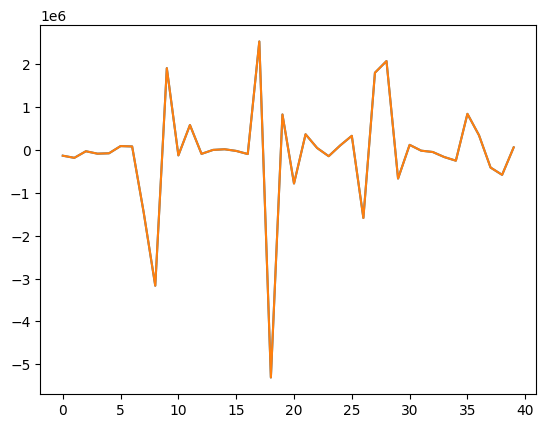

In [70]:
plt.plot(mosek_sln)
plt.plot(quadcoil_sln)

In [71]:
K_theta_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_K_theta,
    b_K_theta, 
    c_K_theta, 
    current_scale
)
f_B_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_f_B,
    b_f_B, 
    c_f_B, 
    current_scale
)
KK_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_KK_cyl,
    b_KK_cyl, 
    c_KK_cyl, 
    current_scale
)
K2_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_K2,
    b_K2, 
    c_K2, 
    current_scale
)


def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

print('MOSEK min K theta', format_e(jnp.min(K_theta_eval(mosek_sln))), 'K theta max', format_e(jnp.max(K_theta_eval(mosek_sln))))
print('Aug   min K theta', format_e(jnp.min(K_theta_eval(quadcoil_sln))), 'K theta max', format_e(jnp.max(K_theta_eval(mosek_sln))))

print('MOSEK max K2', format_e(jnp.max(K2_eval(mosek_sln))), 'K2 max', format_e(max_K2))
print('Aug   max K2', format_e(jnp.max(K2_eval(quadcoil_sln))), 'K2 max', format_e(max_K2))

print('MOSEK KK comp', format_e(jnp.max(jnp.abs(KK_eval(mosek_sln)))), 'KK max', format_e(max_KK))
print('Aug   KK comp', format_e(jnp.max(jnp.abs(KK_eval(quadcoil_sln)))), 'KK max', format_e(max_KK))

print('Mosek f_B', format_e(f_B_eval(mosek_sln)))
print('Aug   f_B', format_e(f_B_eval(quadcoil_sln)))

MOSEK min K theta 1.667983E+00 K theta max 5.165917E+08
Aug   min K theta -2.128639E+03 K theta max 5.165917E+08
MOSEK max K2 2.216172E+14 K2 max 2.216172E+14
Aug   max K2 2.216174E+14 K2 max 2.216172E+14
MOSEK KK comp 3.86073E+14 KK max 6.501226E+14
Aug   KK comp 3.860713E+14 KK max 6.501226E+14
Mosek f_B 5.182883E+01
Aug   f_B 5.182878E+01


# Testing derivative

In [63]:
import jax.profiler

In [64]:
from jax import jacfwd, jacrev, jacobian
# fwd is better for more outputs than inputs
# rev is better for more inputs than outputs

In [65]:
simple_call_fit = lambda x:plasma_dofs_to_winding_dofs(
    # Dofs
    plasma_dofs=x,
    # Equilibrium and related parameters
    # Coil parameters
    coil_plasma_distance=coil_plasma_distance,
    # Numerical parameters
    nfp=nfp, 
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma,
    quadpoints_theta_plasma=quadpoints_theta_plasma,
    mpol_winding=7, 
    ntor_winding=7,
)[0]

In [66]:
d_study_fit = jacobian(simple_call_fit)

In [69]:
d_study_fit(plasma_dofs)

Array([[ 9.97619543e-01,  1.00366437e-01, -2.00750072e-01, ...,
        -2.46824717e-02,  1.71673919e-02, -1.49131354e-02],
       [-1.45418185e-03,  5.71057827e-01,  8.20143661e-02, ...,
        -5.68695145e-02,  9.18162801e-04,  3.67104497e-02],
       [-2.68894043e-03,  8.09146256e-02,  2.82967753e-01, ...,
         4.81284784e-02, -4.65631384e-02,  1.87472948e-02],
       ...,
       [-1.70962843e-04, -1.30838274e-02, -1.00293658e-02, ...,
        -2.09676588e-01,  1.92501426e-02,  2.51681407e-02],
       [ 4.81214724e-04, -3.92577115e-03, -1.40990118e-02, ...,
         3.54179090e-02, -2.26755270e-01,  1.10821869e-02],
       [-1.37809294e-04, -2.85679226e-04, -2.94879472e-03, ...,
         2.97532457e-02,  5.68213481e-02, -1.73799469e-01]],      dtype=float64)

In [26]:
simple_call = lambda x: quadcoil_curvature_study(
    # Dofs
    plasma_dofs=x,

    # Equilibrium and related parameters
    Bnormal_plasma=Bnormal_plasma,
    net_poloidal_current_amperes=net_poloidal_current_amperes, # G
    net_toroidal_current_amperes=net_toroidal_current_amperes, # I

    # Coil parameters
    coil_plasma_distance=coil_plasma_distance,
    max_K2=max_K2,
    max_KK=max_KK,
    
    # Numerical parameters
    nfp=nfp, 
    stellsym=stellsym, 
    mpol_plasma=mpol_plasma,
    ntor_plasma=ntor_plasma,
    quadpoints_phi_plasma=quadpoints_phi_plasma,
    quadpoints_theta_plasma=quadpoints_theta_plasma,

    tol_outer=1e-4,
    tol_inner=1e-4,
    mpol_winding=7,
    ntor_winding=7,
    mpol_cp=4, 
    ntor_cp=4, 
    n_phi_eval_default=32,
    n_theta_eval_default=32,
    
)[0]
d_study = jacfwd(simple_call)
d_study_val = d_study(plasma_dofs)
jax.block_until_ready(d_study_val)
jax.profiler.save_device_memory_profile('diff_memory.prof')

scale_K_theta Traced<ShapedArray(float64[])>with<DynamicJaxprTrace>
c_K_theta shape (32, 32)
quadpoints_phi_eval Traced<ShapedArray(bfloat16[32])>with<DynamicJaxprTrace>
quadpoints_theta_eval Traced<ShapedArray(bfloat16[32])>with<DynamicJaxprTrace>
1024


2025-01-10 19:08:09.842092: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 8.54GiB (9165003438 bytes) by rematerialization; only reduced to 44.30GiB (47563764604 bytes), down from 46.15GiB (49550370076 bytes) originally
2025-01-10 19:08:29.314407: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.36GiB (rounded to 53003005440)requested by op 
2025-01-10 19:08:29.314555: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****________________________________________________________________________________________________
E0110 19:08:29.314584   70584 pjrt_stream_executor_client.cc:3086] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 53003005264 bytes.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 53003005264 bytes.

In [24]:
d_study

<function __main__.<lambda>(x)>